In [2]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import *
import vgg16
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

%matplotlib inline

data_dir = os.path.join(os.getcwd(), 'data', 'whale')
full_img_dir = os.path.join(os.getcwd(), 'data', 'whale', 'imgs')
img_dir  = os.path.join(os.getcwd(), 'data', 'whale', 'for_bb')
resize_dir = os.path.join(os.getcwd(), 'data', 'whale', 'resized')
crop_dir = os.path.join(data_dir, 'crops')
batch_size=64
num_class = 447
img_shape=(3, 224, 224)
target_size = (224,224)

In [3]:
crop_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/whale/crops'

In [4]:
% cd $img_dir

/home/ubuntu/courses/deeplearning1/nbs/data/whale/for_bb


In [5]:
points1 = pd.read_json(data_dir +'/points1.json')

In [6]:
points1.head()

,annotations,class,filename
0,"[{u'y': 864.388663968, u'x': 1361.87854251, u'...",image,w_1.jpg
1,"[{u'y': 573.431704885, u'x': 1242.16151545, u'...",image,w_100.jpg
2,"[{u'y': 908.634097707, u'x': 1633.4995015, u'c...",image,w_1000.jpg
3,"[{u'y': 784.079760718, u'x': 2431.87238285, u'...",image,w_1003.jpg
4,"[{u'y': 1567.77666999, u'x': 3972.84945165, u'...",image,w_1004.jpg


In [7]:
points2 = pd.read_json(data_dir +'/points2.json')

In [8]:
def getProp(x, prop):
    return x[0][prop]

In [9]:
points1['x'] = points1.annotations.apply(lambda v: getProp(v, 'x'))
points1['y'] = points1.annotations.apply(lambda v: getProp(v, 'y'))
points2['x'] = points2.annotations.apply(lambda v: getProp(v, 'x'))
points2['y'] = points2.annotations.apply(lambda v: getProp(v, 'y'))

In [10]:
points1.head()

,annotations,class,filename,x,y
0,"[{u'y': 864.388663968, u'x': 1361.87854251, u'...",image,w_1.jpg,1361.878543,864.388664
1,"[{u'y': 573.431704885, u'x': 1242.16151545, u'...",image,w_100.jpg,1242.161515,573.431705
2,"[{u'y': 908.634097707, u'x': 1633.4995015, u'c...",image,w_1000.jpg,1633.499501,908.634098
3,"[{u'y': 784.079760718, u'x': 2431.87238285, u'...",image,w_1003.jpg,2431.872383,784.079761
4,"[{u'y': 1567.77666999, u'x': 3972.84945165, u'...",image,w_1004.jpg,3972.849452,1567.776670


In [11]:
points2.head()

,annotations,class,filename,x,y
0,"[{u'y': 903.773279352, u'x': 1573.31174089, u'...",image,w_1.jpg,1573.311741,903.773279
1,"[{u'y': 384.478564307, u'x': 1289.8105683, u'c...",image,w_100.jpg,1289.810568,384.478564
2,"[{u'y': 1057.69092722, u'x': 1615.1226321, u'c...",image,w_1000.jpg,1615.122632,1057.690927
3,"[{u'y': 939.26221336, u'x': 2209.30807577, u'c...",image,w_1003.jpg,2209.308076,939.262213
4,"[{u'y': 1550.54835494, u'x': 3583.48953141, u'...",image,w_1004.jpg,3583.489531,1550.548355


In [12]:
points1.to_csv('points1.csv', index=False)
points2.to_csv('points2.csv', index=False)

In [13]:
points1 = pd.read_csv('points1.csv')
points2 = pd.read_csv('points2.csv')

In [14]:
tr = pd.read_csv(data_dir + '/train.csv')

In [15]:
tr[tr.Image == 'w_1.jpg']

,Image,whaleID
2230,w_1.jpg,whale_72820


In [34]:
im = Image.open(os.path.join(img_dir, 'train', 'whale_72820',  'w_1.jpg'))

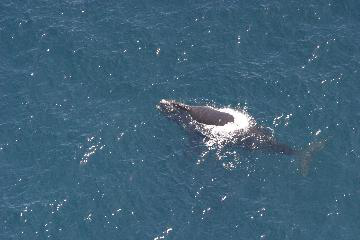

In [35]:
im

In [31]:
ann = pd.read_csv(data_dir + '/ann_adj_360_240.csv')

In [17]:
targ = ann[ann.Image == 'w_1.jpg']

In [32]:
ann.columns

Index([u'Unnamed: 0', u'Image', u'whaleID', u'Unnamed: 0.1', u'annotations',
       u'class', u'filename', u'jpg', u'height', u'width', u'x', u'y',
       u'act_width', u'act_height', u'ratio_act_smaller', u'adj_height',
       u'adj_width', u'adj_x', u'adj_y', u'ratio_width', u'ratio_height'],
      dtype='object')

In [33]:
ann = ann[['Image', 'whaleID', 'height', 'width', 'act_width', 'act_height', 'x', 'y']]

In [34]:
ann.head()

,Image,whaleID,height,width,act_width,act_height,x,y
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460


In [35]:
ann = ann.rename(columns={'act_width': 'image_width', 'act_height': 'image_height', 'x': 'bboxx', 'y': 'bboxy'})

In [36]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460


In [37]:
points1 = points1[['filename', 'x', 'y']]

In [38]:
points2 = points2[['filename', 'x', 'y']]

In [39]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460


In [42]:
points = points1.merge(points2, on='filename', suffixes=('_1', '_2'))

In [44]:
points.head()

,filename,x_1,y_1,x_2,y_2
0,w_1.jpg,1361.878543,864.388664,1573.311741,903.773279
1,w_100.jpg,1242.161515,573.431705,1289.810568,384.478564
2,w_1000.jpg,1633.499501,908.634098,1615.122632,1057.690927
3,w_1003.jpg,2431.872383,784.079761,2209.308076,939.262213
4,w_1004.jpg,3972.849452,1567.776670,3583.489531,1550.548355


In [45]:
ann = ann.merge(points, left_on='Image', right_on='filename')

In [169]:
ann.tail()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
4539,w_9399.jpg,whale_09651,482.154012,476.547570,2464,1648,868.998510,504.579780,w_9399.jpg,1112.358923,584.933200,1031.848455,777.172483
4540,w_9403.jpg,whale_06967,219.548629,318.699623,3072,2048,2377.263116,1411.721294,w_9403.jpg,2623.808574,1494.652044,2437.998006,1480.358923
4541,w_9428.jpg,whale_55333,395.254161,399.206703,3072,2048,1494.060729,1288.528565,w_9428.jpg,1602.871386,1562.033898,1717.216351,1433.395813
4542,w_9450.jpg,whale_24458,469.338312,529.253841,3072,2048,279.605803,129.816980,w_9450.jpg,481.882353,218.480558,684.027916,441.044865
4543,w_9468.jpg,whale_66205,489.310155,535.911122,3072,2048,1388.043093,812.188284,w_9468.jpg,1739.676969,888.215354,1643.708873,1025.020937


# Rotate

In [170]:
targ = ann[ann.Image == 'w_9403.jpg']

In [171]:
im = Image.open(full_img_dir + '/'+ targ.Image.values[0] )

In [172]:
targ

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
4540,w_9403.jpg,whale_06967,219.548629,318.699623,3072,2048,2377.263116,1411.721294,w_9403.jpg,2623.808574,1494.652044,2437.998006,1480.358923


In [173]:
targ

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
4540,w_9403.jpg,whale_06967,219.548629,318.699623,3072,2048,2377.263116,1411.721294,w_9403.jpg,2623.808574,1494.652044,2437.998006,1480.358923


In [174]:
cropped = im.crop((targ.bboxx, targ.bboxy, targ.bboxx + targ.width, targ.bboxy + targ.height))
#crop = img.crop((adj_x, adj_y, adj_x + adj_w, adj_y + adj_h))

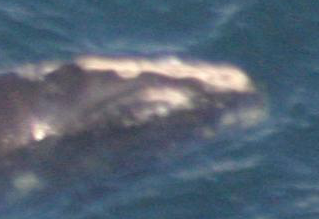

In [175]:
cropped

In [176]:
target_width = 300
target_height = 268

In [177]:
x1_crop = targ.x_1 - targ.bboxx
x2_crop = targ.x_2 - targ.bboxx
x1_final = (target_width / targ.width) * x1_crop
x2_final = (target_width / targ.width) * x2_crop


In [178]:
y1_crop = targ.y_1 - targ.bboxy
y2_crop = targ.y_2 - targ.bboxy
y1_final = (target_height / targ.height) * y1_crop
y2_final = (target_height / targ.height) * y2_crop


In [179]:
x1_final, y1_final

(4540    232.079463
 dtype: float64, 4540    101.232428
 dtype: float64)

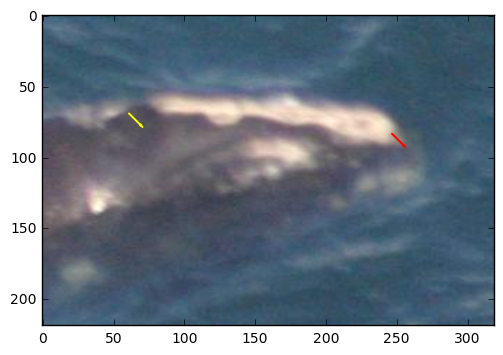

In [180]:
img_arr = np.array(cropped, dtype=np.uint8)

ar1 = patches.Arrow(x1_crop, y1_crop, 10, 10, width=2.0, color='red')
ar2 = patches.Arrow(x2_crop, y2_crop, 10, 10, width=2.0, color='yellow')


    # Create figure and axes
fig,ax = plt.subplots(1)

    # Display the image
ax.imshow(img_arr)
ax.add_patch(ar1)
ax.add_patch(ar2)

     # Create a Rectangle patch
plt.show()

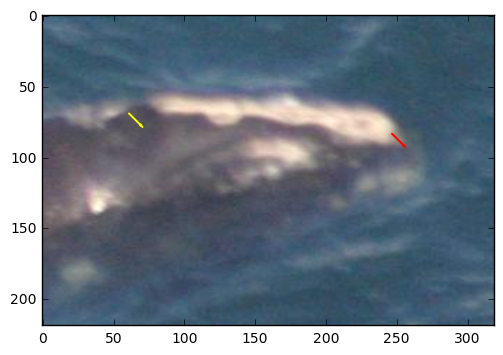

In [181]:
img_arr = np.array(cropped, dtype=np.uint8)

ar1 = patches.Arrow(x1_crop, y1_crop, 10, 10, width=2.0, color='red')
ar2 = patches.Arrow(x2_crop, y2_crop, 10, 10, width=2.0, color='yellow')


    # Create figure and axes
fig,ax = plt.subplots(1)

    # Display the image
ax.imshow(img_arr)
ax.add_patch(ar1)
ax.add_patch(ar2)

     # Create a Rectangle patch
plt.show()

In [182]:
cropped.rotate?

In [183]:
Image.NEAREST?

In [184]:
r = cropped.rotate(bearing(x1_crop, y1_crop, x2_crop, y2_crop), resample=Image.NEAREST, expand=True)

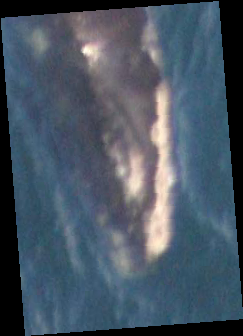

In [185]:
r

In [127]:
def bearing(a1, a2,  b1,  b2):
    # https://math.stackexchange.com/questions/1596513/find-the-bearing-angle-between-two-points-in-a-2d-space
    TWOPI = 6.2831853071795865;
    RAD2DEG = 57.2957795130823209;
    
    theta = math.atan2(b1 - a1, a2 - b2);
    if theta < 0.0:
        theta += TWOPI;
    return RAD2DEG * theta;


103.6713071316475

In [107]:
math.asin((18.75))

ValueError: math domain error

In [96]:
import math
math.degrees(math.asin((y_diff/ x_diff)))

ValueError: math domain error

In [79]:
import math
math.degrees(math.asin((y_diff/ x_diff)))

-10.702779651500437

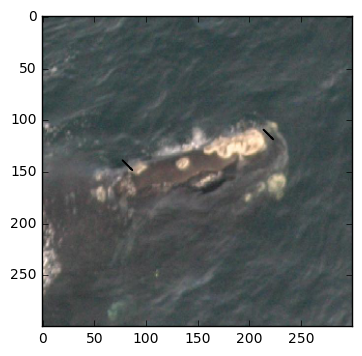

In [119]:
small = cropped.resize((target_size, target_size))


img_arr = np.array(small, dtype=np.uint8)

ar1 = patches.Arrow(x1_final, y1_final, 10, 10, width=2.0)
ar2 = patches.Arrow(x2_final, y2_final, 10, 10, width=2.0)


    # Create figure and axes
fig,ax = plt.subplots(1)

    # Display the image
ax.imshow(img_arr)
ax.add_patch(ar1)
ax.add_patch(ar2)

     # Create a Rectangle patch

plt.show()

In [80]:
g = os.walk(os.path.join(img_dir, 'test', 'unknown'))

In [81]:
p,d,f = g.next()

In [83]:
t = Image.open(os.path.join(img_dir, 'test', 'unknown', 'w_8037.jpg'))

In [84]:
t.size

(360, 240)

You want to have the images in a size you can train with. Maybe 224, 224?

So, what to do.
You just want the heads. Which you can get from the crops.
Then you adjust where the points are --- which you've done above.
Then you need to adjust where those points are for your target size. Maybe a target size of 300, 300? 
So do this for all the train images.






In [41]:
cropped = Image.open(os.path.join(resize_dir, 'w_1.jpg'))

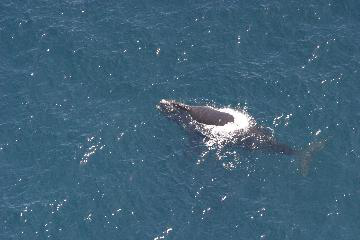

In [42]:
cropped

In [87]:
patches.Arrow?

In [ ]:
def check_smaller(names, bboxes):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    bbox = bboxes[idx,:]    
    
    f_name = resize_dir + '/' + f
    img = Image.open(f_name)
    img = img.resize((224,224))
    img_arr = np.array(img, dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
    rect = patches.Rectangle((bbox[2],bbox[3] ),
                             bbox[0],
                             bbox[1], 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    print(f)
    plt.show()

    

In [81]:
x1_adj = (360 / targ.act_width) * targ.x_1

In [82]:
x1_adj

2230    159.595142
dtype: float64

In [2]:
data_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/whale'

In [3]:
img_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/whale/imgs'

In [6]:
def get_tr_batches(dr = img_dir+ '/train', gen = ImageDataGenerator(), batch_size=batch_size):
    return gen.flow_from_directory(dr, shuffle=True, target_size=target_size, batch_size=64)

def get_val_batches(dr = img_dir+ '/valid', gen = ImageDataGenerator(), batch_size=batch_size):
    return gen.flow_from_directory(dr, shuffle=False, target_size=target_size, batch_size=batch_size)


In [8]:
tr_b = get_tr_batches()
val_b = get_val_batches()

Found 4089 images belonging to 447 classes.
Found 455 images belonging to 447 classes.


In [9]:
ann = pd.read_csv('data/whale/ann_adj_224_224.csv')

In [10]:
tr_files= [f[f.find('/')+1:] for f in tr_b.filenames]

In [11]:
val_files = [f[f.find('/')+1:] for f in val_b.filenames]

In [12]:
tr_ann = ann[ann.Image.isin(tr_files)]

In [13]:
val_ann = ann[ann.Image.isin(val_files)]

In [14]:
def check_smaller(names, bboxes):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    bbox = bboxes[idx,:]    
    
    f_name = resize_dir + '/' + f
    img = Image.open(f_name)
    img = img.resize((224,224))
    img_arr = np.array(img, dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
    rect = patches.Rectangle((bbox[2],bbox[3] ),
                             bbox[0],
                             bbox[1], 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    print(f)
    plt.show()



In [15]:
tr_y = []
for f in tr_files:
    r = tr_ann[tr_ann.Image == f]
    w = r.adj_width.values[0]
    h = r.adj_height.values[0]
    x = r.adj_x.values[0]
    y = r.adj_y.values[0]
    tr_y.append([w,h,x,y])

In [16]:
val_y = []
for f in val_files:
    r = val_ann[val_ann.Image == f]
    w = r.adj_width.values[0]
    h = r.adj_height.values[0]
    x = r.adj_x.values[0]
    y = r.adj_y.values[0]
    val_y.append([w,h,x,y])

In [17]:
tr_y = np.array(tr_y)

In [18]:
val_y = np.array(val_y)

In [19]:
tr_y.shape

(4089, 4)

In [20]:
val_y.shape

(455, 4)

2318
w_5528.jpg


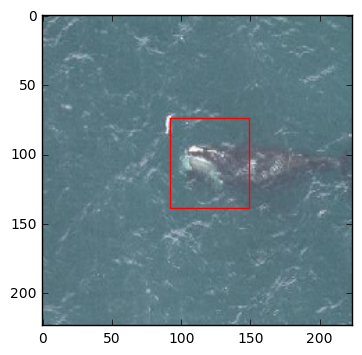

In [21]:
check_smaller(tr_files, tr_y)

450
w_6704.jpg


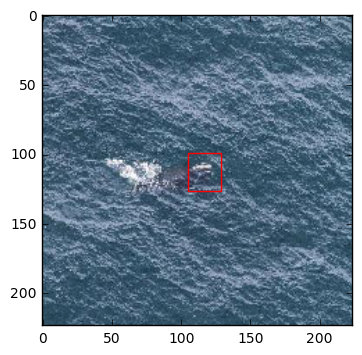

In [22]:
check_smaller(val_files, val_y)

# Don't use precomputed features

In [ ]:
del tr_features
del val_features

In [23]:
tr_b = ImageDataGenerator().flow_from_directory(img_dir+'/train',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 4089 images belonging to 447 classes.


In [24]:
val_b = ImageDataGenerator().flow_from_directory(img_dir+'/valid',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 455 images belonging to 447 classes.


In [25]:
tr_files = tr_b.filenames

In [26]:
val_files = val_b.filenames

In [27]:
tr_data = np.concatenate([tr_b.next() for i in range(tr_b.nb_sample)])

In [28]:
val_data = np.concatenate([val_b.next() for i in range(val_b.nb_sample)])

In [29]:
save_array('tr_data_224_224_for_bb_reg.bc', tr_data)

In [30]:
save_array('tr_filenames_for_bb_reg.bc', tr_files)

In [31]:
save_array('val_data_224_224_for_bb_reg.bc', val_data)

In [32]:
save_array('val_filenames_for_bb_reg.bc', val_files)

In [4]:
tr_data = load_array('tr_data_224_224.bc')
val_data = load_array('val_data_224_224.bc')
tr_files = load_array('tr_filenames.bc')
val_files = load_array('val_filenames.bc')

In [33]:
print(tr_data.shape)
print(val_data.shape)
print(tr_files[0])
print(val_files[0])


(4089, 3, 224, 224)
(455, 3, 224, 224)
whale_00195/w_3733.jpg
whale_00195/w_9186.jpg


In [34]:
tr_files= [f[f.find('/')+1:] for f in tr_files]

In [35]:
val_files = [f[f.find('/')+1:] for f in val_files]

In [36]:
tr_ann = ann[ann.Image.isin(tr_files)]

In [37]:
val_ann = ann[ann.Image.isin(val_files)]

In [38]:
tr_y = []
for f in tr_files:
    r = tr_ann[tr_ann.Image == f]
    w = r.adj_width.values[0]
    h = r.adj_height.values[0]
    x = r.adj_x.values[0]
    y = r.adj_y.values[0]
    tr_y.append([w,h,x,y])

In [39]:
val_y = []
for f in val_files:
    r = val_ann[val_ann.Image == f]
    w = r.adj_width.values[0]
    h = r.adj_height.values[0]
    x = r.adj_x.values[0]
    y = r.adj_y.values[0]
    val_y.append([w,h,x,y])

In [40]:
tr_y = np.array(tr_y)

In [41]:
val_y = np.array(val_y)

In [42]:
tr_y.shape

(4089, 4)

In [43]:
val_y.shape

(455, 4)

In [44]:
tr_data.shape

(4089, 3, 224, 224)

In [45]:
tr_mean = np.mean(tr_data, axis=(0,2,3))

In [46]:
tr_mean.shape

(3,)

In [47]:
tr_mean.reshape((3,1,1))

array([[[  71.9239]],

       [[  94.8318]],

       [[ 108.0106]]])

In [48]:
tr_mean_r = tr_mean.reshape((3,1,1))

# Fit on sample

In [20]:
tr_idx = np.random.permutation(tr_data.shape[0])[:500]

In [21]:
val_idx = np.random.permutation(val_data.shape[0])[:150]

In [22]:
tr_samp_x = tr_data[tr_idx, :, :, :]

In [23]:
tr_samp_y = tr_y[tr_idx,:]

In [24]:
val_samp_x = val_data[val_idx, :,:,:]

In [25]:
val_samp_y = val_y[val_idx, :]

In [51]:
def std(x): 
    x = x-tr_mean.reshape((3,1,1))
    return x

In [27]:
def get_model():
    return Sequential([
            Lambda(std, input_shape=(3, 224,224)),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(512, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(4)
        ])

In [34]:
model = get_model()

In [35]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [36]:
model.fit(tr_samp_x, tr_samp_y, validation_data=(val_samp_x, val_samp_y), shuffle=True, nb_epoch=5)

Train on 500 samples, validate on 150 samples
Epoch 1/5
500/500 [==============================] - 40s - loss: 3532.3466 - acc: 0.4920 - val_loss: 608334.5250 - val_acc: 0.5733
Epoch 2/5
500/500 [==============================] - 40s - loss: 552.1993 - acc: 0.6420 - val_loss: 61124.0692 - val_acc: 0.4867
Epoch 3/5
500/500 [==============================] - 40s - loss: 358.2080 - acc: 0.6900 - val_loss: 21967.5940 - val_acc: 0.4267
Epoch 4/5
500/500 [==============================] - 40s - loss: 326.9887 - acc: 0.7300 - val_loss: 7056.0112 - val_acc: 0.4400
Epoch 5/5
500/500 [==============================] - 40s - loss: 219.5490 - acc: 0.7660 - val_loss: 2744.9662 - val_acc: 0.5333


In [37]:
model.fit(tr_samp_x, tr_samp_y, validation_data=(val_samp_x, val_samp_y), shuffle=True, nb_epoch=2)

Train on 500 samples, validate on 150 samples
Epoch 1/2
500/500 [==============================] - 40s - loss: 211.8858 - acc: 0.7560 - val_loss: 1593.0449 - val_acc: 0.6733
Epoch 2/2
500/500 [==============================] - 40s - loss: 186.1039 - acc: 0.7720 - val_loss: 996.9879 - val_acc: 0.6200


In [38]:
model.fit(tr_samp_x, tr_samp_y, validation_data=(val_samp_x, val_samp_y), shuffle=True, nb_epoch=2)

Train on 500 samples, validate on 150 samples
Epoch 1/2
500/500 [==============================] - 40s - loss: 177.9758 - acc: 0.7740 - val_loss: 708.4437 - val_acc: 0.6067
Epoch 2/2
500/500 [==============================] - 40s - loss: 182.6905 - acc: 0.7620 - val_loss: 564.3958 - val_acc: 0.6667


In [39]:
model.fit(tr_samp_x, tr_samp_y, validation_data=(val_samp_x, val_samp_y), shuffle=True, nb_epoch=2)

Train on 500 samples, validate on 150 samples
Epoch 1/2
500/500 [==============================] - 40s - loss: 184.8669 - acc: 0.7900 - val_loss: 507.6435 - val_acc: 0.6000
Epoch 2/2
500/500 [==============================] - 40s - loss: 169.9879 - acc: 0.8300 - val_loss: 552.1860 - val_acc: 0.6533


### Diff loss on sample

In [28]:
def get_model():
    return Sequential([
            Lambda(std, input_shape=(3, 224,224)),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(512, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(4)
        ])

In [29]:
model = get_model()

In [30]:
import numpy as np
import theano.tensor as T
from theano import function

In [31]:
def l2_distance(y_true, y_pred):
    return (T.sqrt(T.sum(T.power((y_true- y_pred),2), axis=1)))


In [33]:
model.compile(Adam(lr=0.001), loss=l2_distance, metrics=['accuracy'])

In [34]:
model.fit(tr_samp_x, tr_samp_y, validation_data=(val_samp_x, val_samp_y), shuffle=True, nb_epoch=5)

Train on 500 samples, validate on 150 samples
Epoch 1/5
500/500 [==============================] - 40s - loss: 105.9253 - acc: 0.5080 - val_loss: 1153.5520 - val_acc: 0.2333
Epoch 2/5
500/500 [==============================] - 39s - loss: 40.6645 - acc: 0.6100 - val_loss: 727.8492 - val_acc: 0.3800
Epoch 3/5
500/500 [==============================] - 40s - loss: 38.9071 - acc: 0.6740 - val_loss: 219.7691 - val_acc: 0.2333
Epoch 4/5
500/500 [==============================] - 39s - loss: 34.7502 - acc: 0.6800 - val_loss: 155.7201 - val_acc: 0.2133
Epoch 5/5
500/500 [==============================] - 39s - loss: 31.1711 - acc: 0.7100 - val_loss: 105.9654 - val_acc: 0.3200


### Deeper of sample

In [35]:
def get_model():
    return Sequential([
            Lambda(std, input_shape=(3, 224,224)),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(512, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(1024, activation='relu'),
            Dense(512, activation='relu'),
            Dense(4)
        ])

In [36]:
model = get_model()

In [37]:
model.compile(Adam(lr=0.001), loss=l2_distance, metrics=['accuracy'])

In [38]:
model.fit(tr_samp_x, tr_samp_y, validation_data=(val_samp_x, val_samp_y), shuffle=True, nb_epoch=5)

Train on 500 samples, validate on 150 samples
Epoch 1/5
500/500 [==============================] - 58s - loss: 85.4041 - acc: 0.4720 - val_loss: 7163.8212 - val_acc: 0.0333
Epoch 2/5
500/500 [==============================] - 58s - loss: 39.3342 - acc: 0.5760 - val_loss: 2386.7149 - val_acc: 0.3467
Epoch 3/5
500/500 [==============================] - 58s - loss: 37.2021 - acc: 0.6180 - val_loss: 782.7681 - val_acc: 0.5267
Epoch 4/5
500/500 [==============================] - 59s - loss: 34.3856 - acc: 0.6900 - val_loss: 343.4237 - val_acc: 0.2133
Epoch 5/5
500/500 [==============================] - 59s - loss: 34.9194 - acc: 0.6860 - val_loss: 191.5944 - val_acc: 0.5667


In [39]:
model = get_model()

In [40]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [41]:
model.fit(tr_samp_x, tr_samp_y, validation_data=(val_samp_x, val_samp_y), shuffle=True, nb_epoch=5)

Train on 500 samples, validate on 150 samples
Epoch 1/5
500/500 [==============================] - 58s - loss: 2758.8790 - acc: 0.4820 - val_loss: 25133011.6000 - val_acc: 0.0400
Epoch 2/5
500/500 [==============================] - 58s - loss: 554.4869 - acc: 0.6000 - val_loss: 1793247.3617 - val_acc: 0.3667
Epoch 3/5
500/500 [==============================] - 58s - loss: 391.0276 - acc: 0.6240 - val_loss: 286883.7183 - val_acc: 0.4400
Epoch 4/5
500/500 [==============================] - 58s - loss: 374.2036 - acc: 0.6940 - val_loss: 17247.9128 - val_acc: 0.4400
Epoch 5/5
500/500 [==============================] - 58s - loss: 332.7680 - acc: 0.6780 - val_loss: 7093.4584 - val_acc: 0.4800


In [91]:
model.save_weights('bb_reg_298.h5')

In [92]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=1)

Train on 4092 samples, validate on 452 samples
Epoch 1/1
4092/4092 [==============================] - 290s - loss: 251.5358 - acc: 0.7432 - val_loss: 253.2900 - val_acc: 0.7500


In [93]:
model.save_weights('bb_reg_253.h5')

In [47]:
model.load_weights('bb_reg_253.h5')

In [48]:
val_preds = model.predict(val_data)

In [49]:
val_preds.shape

(452, 4)

450
w_2809.jpg


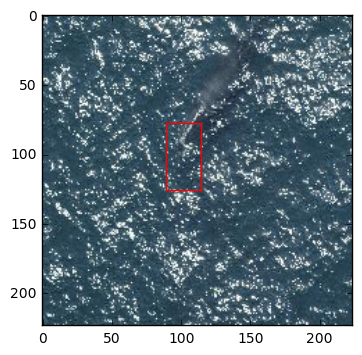

In [74]:
check_smaller(bboxes=val_preds, names=val_files)

# Deeper Model

In [49]:
def get_model():
    return Sequential([
            Lambda(std, input_shape=(3, 224,224)),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(512, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(1024, activation='relu'),
            Dense(512, activation='relu'),
            Dense(4)
        ])

In [52]:
model = get_model()

In [53]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [54]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=20)

Train on 4089 samples, validate on 455 samples
Epoch 1/20
4089/4089 [==============================] - 450s - loss: 778.5625 - acc: 0.5730 - val_loss: 632.4707 - val_acc: 0.5297
Epoch 2/20
4089/4089 [==============================] - 449s - loss: 317.9883 - acc: 0.6733 - val_loss: 248.5728 - val_acc: 0.6967
Epoch 3/20
4089/4089 [==============================] - 449s - loss: 274.9032 - acc: 0.7298 - val_loss: 239.9020 - val_acc: 0.6527
Epoch 4/20
4089/4089 [==============================] - 449s - loss: 238.0991 - acc: 0.7542 - val_loss: 191.7257 - val_acc: 0.7648
Epoch 5/20
4089/4089 [==============================] - 449s - loss: 213.5765 - acc: 0.7821 - val_loss: 190.0608 - val_acc: 0.7165
Epoch 6/20
4089/4089 [==============================] - 450s - loss: 195.7947 - acc: 0.7948 - val_loss: 213.5234 - val_acc: 0.7560
Epoch 7/20
4089/4089 [==============================] - 451s - loss: 177.8752 - acc: 0.8031 - val_loss: 180.2426 - val_acc: 0.7538
Epoch 8/20
4089/4089 [==============

KeyboardInterrupt: 

In [55]:
model.save_weights('whale_bb_137.h5')

In [56]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 106.7081 - acc: 0.8638 - val_loss: 131.0938 - val_acc: 0.8308
Epoch 2/10
4089/4089 [==============================] - 450s - loss: 105.2361 - acc: 0.8655 - val_loss: 124.7798 - val_acc: 0.8242
Epoch 3/10
4089/4089 [==============================] - 450s - loss: 92.5360 - acc: 0.8802 - val_loss: 185.1914 - val_acc: 0.8066
Epoch 4/10
4089/4089 [==============================] - 450s - loss: 86.2257 - acc: 0.8792 - val_loss: 148.2277 - val_acc: 0.8264
Epoch 5/10
4089/4089 [==============================] - 450s - loss: 80.8730 - acc: 0.8826 - val_loss: 129.3283 - val_acc: 0.8286
Epoch 6/10
 768/4089 [====>.........................] - ETA: 354s - loss: 71.0460 - acc: 0.8802

KeyboardInterrupt: 

In [57]:
model.save_weights('whale_bb_129.h5')

In [56]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 106.7081 - acc: 0.8638 - val_loss: 131.0938 - val_acc: 0.8308
Epoch 2/10
4089/4089 [==============================] - 450s - loss: 105.2361 - acc: 0.8655 - val_loss: 124.7798 - val_acc: 0.8242
Epoch 3/10
4089/4089 [==============================] - 450s - loss: 92.5360 - acc: 0.8802 - val_loss: 185.1914 - val_acc: 0.8066
Epoch 4/10
4089/4089 [==============================] - 450s - loss: 86.2257 - acc: 0.8792 - val_loss: 148.2277 - val_acc: 0.8264
Epoch 5/10
4089/4089 [==============================] - 450s - loss: 80.8730 - acc: 0.8826 - val_loss: 129.3283 - val_acc: 0.8286
Epoch 6/10
 768/4089 [====>.........................] - ETA: 354s - loss: 71.0460 - acc: 0.8802

KeyboardInterrupt: 

In [59]:
model.save_weights('whale_bb_122.h5')

In [60]:
model.optimizer.lr = 0.0001

In [61]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 39.2634 - acc: 0.9171 - val_loss: 138.6453 - val_acc: 0.8286
Epoch 2/10
4089/4089 [==============================] - 449s - loss: 38.2008 - acc: 0.9156 - val_loss: 131.2853 - val_acc: 0.8418
Epoch 3/10
4089/4089 [==============================] - 449s - loss: 39.7533 - acc: 0.9235 - val_loss: 130.9264 - val_acc: 0.8374
Epoch 4/10
4089/4089 [==============================] - 451s - loss: 32.5617 - acc: 0.9254 - val_loss: 121.4119 - val_acc: 0.8396
Epoch 5/10
4089/4089 [==============================] - 451s - loss: 31.3996 - acc: 0.9269 - val_loss: 124.0389 - val_acc: 0.8352
Epoch 6/10
4089/4089 [==============================] - 450s - loss: 27.6569 - acc: 0.9337 - val_loss: 129.1431 - val_acc: 0.8571
Epoch 7/10
4089/4089 [==============================] - 450s - loss: 25.9184 - acc: 0.9354 - val_loss: 134.1947 - val_acc: 0.8022
Epoch 8/10
4089/4089 [=====================

In [62]:
model.optimizer.lr = 0.00001

In [63]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 18.9432 - acc: 0.9445 - val_loss: 131.1113 - val_acc: 0.8440
Epoch 2/10
4089/4089 [==============================] - 450s - loss: 21.7494 - acc: 0.9401 - val_loss: 121.7423 - val_acc: 0.8418
Epoch 3/10
4089/4089 [==============================] - 449s - loss: 17.3245 - acc: 0.9469 - val_loss: 127.7389 - val_acc: 0.8484
Epoch 4/10
4089/4089 [==============================] - 450s - loss: 15.2120 - acc: 0.9411 - val_loss: 113.5965 - val_acc: 0.8484
Epoch 5/10
4089/4089 [==============================] - 450s - loss: 17.6442 - acc: 0.9411 - val_loss: 122.0209 - val_acc: 0.8374
Epoch 6/10
4089/4089 [==============================] - 451s - loss: 16.8782 - acc: 0.9533 - val_loss: 119.5340 - val_acc: 0.8330
Epoch 7/10
4089/4089 [==============================] - 450s - loss: 15.4750 - acc: 0.9467 - val_loss: 124.3540 - val_acc: 0.8396
Epoch 8/10
4089/4089 [=====================

KeyboardInterrupt: 

In [65]:
model.optimizer.lr = 0.000001

In [66]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=1)

Train on 4089 samples, validate on 455 samples
Epoch 1/1
4089/4089 [==============================] - 450s - loss: 13.0874 - acc: 0.9552 - val_loss: 116.9361 - val_acc: 0.8374


In [67]:
model.save_weights('116.9.h5')

In [68]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=1)

Train on 4089 samples, validate on 455 samples
Epoch 1/1
4089/4089 [==============================] - 450s - loss: 13.6130 - acc: 0.9579 - val_loss: 131.2703 - val_acc: 0.8220


In [69]:
model.load_weights('116.9.h5')

In [70]:
preds = model.predict(val_data)

50
w_5616.jpg


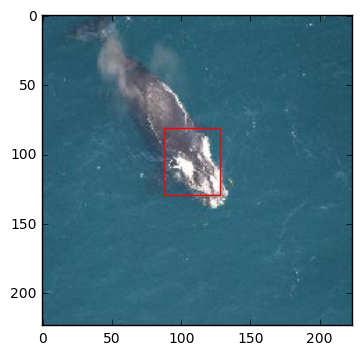

In [90]:
check_smaller(val_files, preds)

# Step forward. Get predictions on test set.

In [91]:
test_b = ImageDataGenerator().flow_from_directory(img_dir+'/test',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 6925 images belonging to 1 classes.


In [92]:
test_files = test_b.filenames

In [93]:
save_array('test_file_names.bc', test_files)

In [94]:
test_data = np.concatenate([test_b.next() for i in range(test_b.nb_sample)])

In [95]:
save_array('test_data_224_224.bc', test_data)

In [96]:
test_preds = model.predict(test_data)

In [99]:
test_files = [f[f.find('/')+1:] for f in test_files]

821
w_2771.jpg


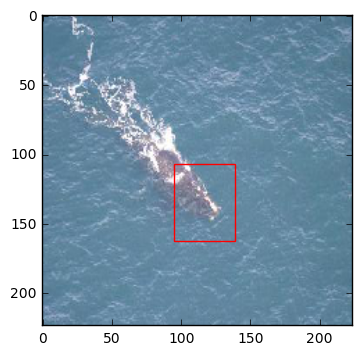

In [124]:
check_smaller(test_files, test_preds)

In [125]:
test_ann = pd.DataFrame(np.hstack((np.array(test_files)[:, np.newaxis], test_preds)), columns=['Image', 'width', 'height', 'x', 'y'])

In [126]:
test_ann.head()

,Image,width,height,x,y
0,w_8037.jpg,29.0913066864,50.4047203064,90.4007720947,98.9544677734
1,w_4494.jpg,32.1990737915,45.0582427979,84.8776702881,57.4592323303
2,w_4673.jpg,44.787689209,54.903339386,103.601135254,91.891708374
3,w_8273.jpg,41.8063430786,50.1853218079,100.628494263,60.9373054504
4,w_7611.jpg,37.7578010559,57.7667121887,120.307563782,76.0566101074


In [128]:
test_ann.to_csv('test_ann.csv', index=False)